# Lab 3.2: **Deep Unfolding Network For Signal Reconstruction**
Welcome to COMSM0159 Advanced Visual AI (AVAI)!

The goal of this labsheet is to illustrate the process of a Deep unfolding network ADMM-DAD.

In this class, you will learn

1. The working principle of the network ADMM-DAD: How to reconstruct better signal from the noisy signal.

2. Construct the structure of the network ADMM-DAD in torch.

3. Train the MINIST dataset based on the script.

In [1]:
!git clone https://github.com/UoB-CS-AVAI/Week3-Deep-Unfolding-Neural-Network.git

Cloning into 'Week3-Deep-Unfolding-Neural-Network'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 15 (delta 6), reused 15 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (15/15), 383.08 KiB | 9.34 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [2]:
import copy
import os
import random
import math
import webbrowser

from datetime import datetime
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import MNIST, CIFAR10
from torchvision.transforms import Compose, Normalize, ToTensor, Grayscale
from tqdm import tqdm

**Parameter settings for the network**

In [3]:
admm_iterations = 5  # Number of ADMM iterations during forward
ambient_dim = 28 * 28  # AMBIENT_DIM -> Vectorized image pixels
num_measurements = round(0.25 * ambient_dim)  # Number of measurements to use for CS
lamda = 1e-4  # positive regularization parameter
rho = 1 # positive penalty parameter of ADMM
redundancy_multiplier = 5 # redundancy ratio of analysis opera    tor
normalize = "sqrt_m" # types of normalization for measurement matr    ix A: 1) None 2) A/sqrt(num_measurements) 3) A*A^T=I

CLIP_GRAD_NORM = 10  # Clip gradients to avoid exploding

learning_rate = 1e-4  # Adam Learning rate
batch_size = 128  # How many images to process in parallel
num_epochs = 200  # Epochs to train

The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems.


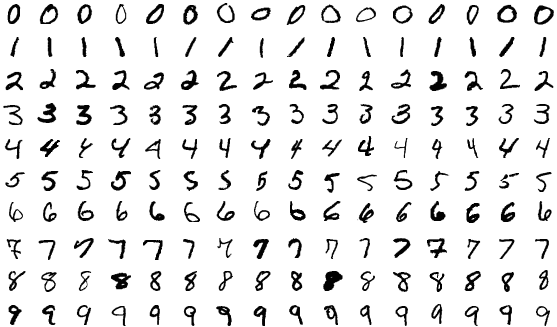



1. Construct the train and test dataset for MNIST

In [4]:
def get_data_loaders(train_batch_size, val_batch_size):
    data_transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
    train = MNIST(download=True, root=".", transform=data_transform, train=True)
    val = MNIST(download=False, root=".", transform=data_transform, train=False)
    train_loader = DataLoader(train, num_workers=2, batch_size=train_batch_size, shuffle=True)
    val_loader = DataLoader(val, num_workers=2, batch_size=val_batch_size, shuffle=False)
    return train_loader, val_loader

In [5]:
def date_fname():
    uniq_filename = (str(datetime.now().date()) + "_" + str(datetime.now().time()).replace(":", "."))
    return uniq_filename

def safe_mkdirs(path: str) -> None:
    """! Makes recursively all the directory in input path """
    if not os.path.exists(path):
        try:
           os.makedirs(path)
        except Exception as e:
            raise IOError((f"Failed to create recursive directories: {path}"))

def save_image(grid, fname):
     from PIL import Image
     ndarr = (grid.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to("cpu", torch.uint8).numpy())
     im = Image.fromarray(ndarr)
     im.save(fname)
     return ndarr

# create folder with saved images
def save_examples(model, val_loader, epoch, algo="admm_mnist", device="cpu")    :
    psnr = PSNR()
    folder = f"results_admm_mnist/{algo}_{date_fname()}_epoch.{epoch}"
    safe_mkdirs(folder)
    idxes = random.sample(range(len(val_loader.dataset)), 16)
    original = torch.stack([val_loader.dataset[i][0] for i in idxes]).to(device)
    reconstructed = model(original).view(original.size(0), 1, 28, 28)
    original = original.detach().cpu()
    reconstructed = reconstructed.detach().cpu()
    # calculate the PSNR for the saved example
    mypsnr = psnr(original,reconstructed)
    print(f"PSNR = {mypsnr}")
    img_orig = torchvision.utils.make_grid(original, nrow=4)
    img_recon = torchvision.utils.make_grid(reconstructed, nrow=4)
    original_image = save_image(img_orig, f"{folder}/original_epoch_{epoch}.jpg")
    reconstructed_image = save_image(img_recon, f"{folder}/reconstructed_epoch_{epoch}.jpg")

    html = """
    <!DOCTYPE html>
    <html>
    <body>
    <h2>Original</h2>
    <img src="original_epoch_{epoch}.jpg" width="500" height="500">
    <h2>Reconstructed</h2>
    <img src="reconstructed_epoch_{epoch}.jpg" width="500" height="500">

    </body>
    </html>
    """.format(
       epoch=epoch
    )
    html_file = f"{folder}/epoch_{epoch}.html"
    with open(html_file, "w") as fd:
        fd.write(html)

    return {"original": original_image,"reconstructed": reconstructed_image,"original_caption": f"Original","reconstructed_caption": f"Reconstructed"}

PSNR is a standard to evaluate the ratio between Signal and Noise

In [6]:
class PSNR:
    # Peak Signal to Noise Ratio for img1 and img2 with maximum pixel value = 1

    def __init__(self):
        self.name = "PSNR"

    def __call__(self, img1, img2):
        mse = torch.mean((img1 - img2) ** 2)
        return 20 * torch.log10(1.0 / torch.sqrt(mse))

def eye_like(tensor):
    return torch.eye(*tensor.size(), out=torch.empty_like(tensor))

Network Structure of ADMM-DAD

**Task 1:**

Acording to the below picture, try to understand how it works and related deployment in torch

if you are interested in ADMM and have free time, read following book to think about how to solve this problem in iterative format after class.

**Related book**

Stephen Boyd, Neal Parikh, and Eric Chu, Distributed
optimization and statistical learning via the alternating
direction method of multipliers, Now Publishers Inc,
2011

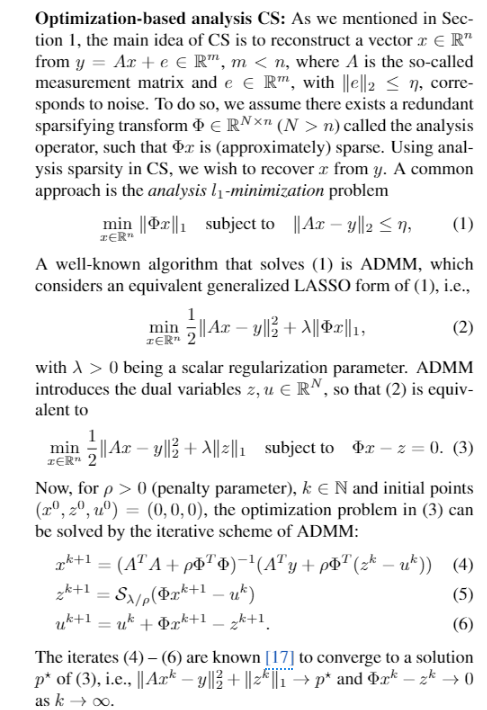

In [7]:
class ShrinkageActivation(nn.Module):
    def __init__(self):
        super(ShrinkageActivation, self).__init__()

    # implements the softh-thresholding function employed in ADMM
    def forward(self, x, lamda):
        return torch.sign(x) * torch.max(torch.zeros_like(x), torch.abs(x) - lamda)


class DAD(nn.Module):
    def __init__(
        self,
        measurements=200,
        ambient=28 * 28,
        redundancy_multiplier=5,
        admm_iterations=10,
        lamda=0.0001,
        rho=1):
        super(DAD, self).__init__()
        self.lamda = lamda
        self.rho = rho
        self.redundancy_multiplier = redundancy_multiplier
        self.admm_iterations = admm_iterations
        self.measurements = measurements

        self.ambient = ambient
        self.activation = ShrinkageActivation()
        a = torch.randn(measurements, ambient)
        if normalize == None:
            a = a
        elif normalize == "sqrt_m":
            a = a/np.sqrt(self.measurements)
        elif normalize == "orth":
            a = torch.nn.init.orthogonal_(a.t()).t().contiguous()
        self.register_buffer("a", a)
        phi = nn.Parameter(self._init_phi())
        self.register_parameter("phi", phi)

    def _init_phi(self):
        # initialization of the analysis operator

        init = torch.empty(self.ambient * self.redundancy_multiplier, self.ambient)
        init = torch.nn.init.kaiming_normal_(init)

        return init

    def extra_repr(self):
        return "(phi): Parameter({}, {})".format(*self.phi.shape)

    def measure_x(self, x):
        # Create measurements y=Ax+noise

        y = torch.einsum("ma,ba->bm", self.a, x)
        n = 1e-4*torch.randn_like(y)
        y = y+n
        return y


    def multiplier(self,rho):
        # m = (A^T*A+Φ^Τ*Φ)^-1
        # Instead of calculating directly the inverse, we take the LU factorization of A^T*A+Φ^Τ*Φ
        ata = torch.mm(self.a.t(), self.a)
        ftf = torch.mm(self.phi.t(),self.phi)
        m = ata + rho * ftf
        m_lu, _ = m.lu()
        _, L, U = torch.lu_unpack(m_lu, _)
        Linv = torch.linalg.inv(L)
        Uinv = torch.linalg.inv(U)
        return Linv, Uinv

    def linear(self, x, u):
        # application of analysis operator Φ
        fx = torch.einsum("sa,ba->bs", self.phi, x)
        return fx + u  # (B, 3*784)

    def decode(self, y, min_x, max_x,u,z):
        rho = self.rho
        lamda = self.lamda
        Linv, Uinv = self.multiplier(rho)
        x0 = torch.einsum("am,bm->ba", self.a.t(), y)
        for _ in range(self.admm_iterations):
            x_L = torch.einsum("aa,ba->ba",Linv, x0 + torch.einsum("as,bs->ba",rho*self.phi.t(),z-u))
            x_hat = torch.einsum("aa,ba->ba",Uinv,x_L)
            fxu = self.linear(x_hat, u)
            z = self.activation(fxu,lamda/rho)
            u = u + fxu - z
        # truncate the reconstructed x_hat, so that it lies in the same values' interval as the original x
        return torch.clamp(x_hat,min=min_x,max=max_x)

    def forward(self, x):
          x = x.view(x.size(0), -1)
          min_x = torch.min(x)
          max_x = torch.max(x)
          # measure x
          y = self.measure_x(x)
          # apply analysis operator Φ
          fx = torch.einsum("sa,ba->bs", self.phi, x)
          #create the dual variables z, u
          u = torch.zeros_like(fx)
          z = torch.zeros_like(fx)
          # pass y through the network-decoder to get the output x_hat
          x_hat = self.decode(y,min_x,max_x,u,z)
          return x_hat

Playground: Understand the training process and try to modify the paramters in the code.(they are located at the place before training)

In [8]:
def train_step(
     model,
     optimizer,
     criterion,
     batch,
     device="cpu",):
     optimizer.zero_grad()
     x_original, _ = batch
     x_original = x_original.to(device)

     def compute_loss():
          x_pred = model(x_original)
          mse = criterion(x_pred, x_original.view(x_original.size(0), -1))

          # we separately keep loss and mse, in case a regularizer is added; in the that case, we would have loss = mse + reg

          loss = mse
          return loss

     x_pred = model(x_original)
     mse = criterion(x_pred, x_original.view(x_original.size(0), -1))
     loss = mse
     loss.backward()
     # torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_GRAD_NORM)
     # optimizer.step(compute_loss)
     optimizer.step()
     return loss, mse


def train_epoch(
    model,
    optimizer,
    criterion,
    train_loader,
    device="cpu",):

    avg_train_loss = 0
    avg_train_mse = 0
    n_proc = 0

    train_iter = tqdm(train_loader, desc="training", leave=False)

    model.train()

    for batch in train_iter:
         n_proc += 1
         loss, mse = train_step(model,optimizer,criterion,batch,device=device)
         avg_train_loss += loss.item()
         avg_train_mse += mse.item()
         train_iter.set_postfix({"loss": "{:.3}".format(avg_train_loss / n_proc)})

    avg_train_loss = avg_train_loss / len(train_loader)
    avg_train_mse = avg_train_mse / len(train_loader)

    return avg_train_loss, avg_train_mse

In [9]:
def val_step(model, criterion, batch, device="cpu"):
    x_original, _ = batch
    x_original = x_original.to(device)
    x_pred = model(x_original)
    mse = criterion(x_pred, x_original.view(x_original.size(0), -1))

    return mse



def val_epoch(model, criterion, val_loader, device="cpu"):
     avg_val_mse = 0
     n_proc = 0
     val_iter = tqdm(val_loader, desc="test", leave=False)
     model.eval()
     for batch in val_iter:
          n_proc += 1
          mse = val_step(model, criterion, batch, device=device)
          avg_val_mse += mse.item()
          val_iter.set_postfix(
              {
                  "mse": "{:.3}".format(avg_val_mse / n_proc),
              }
          )

     # break
     avg_val_mse = avg_val_mse / len(val_loader)
     return avg_val_mse

In [10]:
def train(
    model,
    optimizer,
    criterion,
    train_loader,
    val_loader,
    epochs,
    device="cpu"):
    for e in range(epochs):
        avg_train_loss, avg_train_mse = train_epoch(model, optimizer, criterion, train_loader, device=device)
        avg_val_mse = val_epoch(model, criterion, val_loader, device=device)
        result = save_examples(model, val_loader, e, algo="admm", device=device)

        gen_mse = np.abs(avg_train_mse-avg_val_mse)
        # print in each epoch the average train+test MSEs and the generalization error
        print({"Epoch": e, "Train MSE": avg_train_mse, "Test MSE": avg_val_mse,})
        print("--------------------------------------")
        print("Average Train MSE = {:.4f}".format(avg_train_mse))
        print("--------------------------------------")
        print("Average Test MSE = {:.4f}".format(avg_val_mse))
        print("--------------------------------------")
        print("Average generalization error = {:.6f}".format(gen_mse))
        print("--------------------------------------")
        print("epoch: ", e)
        print("--------------------------------------")

In [11]:
admm_iterations = 5  # Number of ADMM iterations during forward
ambient_dim = 28 * 28  # AMBIENT_DIM -> Vectorized image pixels
num_measurements = round(0.25 * ambient_dim)  # Number of measurements to use for CS
lamda = 1e-4  # positive regularization parameter
rho = 1 # positive penalty parameter of ADMM
redundancy_multiplier = 5 # redundancy ratio of analysis opera    tor
normalize = "sqrt_m" # types of normalization for measurement matr    ix A: 1) None 2) A/sqrt(num_measurements) 3) A*A^T=I

CLIP_GRAD_NORM = 10  # Clip gradients to avoid exploding

learning_rate = 1e-4  # Adam Learning rate
batch_size = 128  # How many images to process in parallel
num_epochs = 200  # Epochs to train

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

train_loader, val_loader = get_data_loaders(batch_size, batch_size)

model = DAD(measurements=num_measurements,ambient=ambient_dim,admm_iterations=admm_iterations,lamda=lamda,rho=rho,redundancy_multiplier=redundancy_multiplier,).to(device)

print(model)
optimizer = Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

epochs = num_epochs

train(model,optimizer,criterion,train_loader,val_loader,epochs,device=device)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 11645371.45it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 346519.79it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2774681.71it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9927320.88it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

DAD(
  (phi): Parameter(3920, 784)
  (activation): ShrinkageActivation()
)


training:   0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:791: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch.lu(A, compute_pivots, get_infos=True)
should be replaced with
LU, pivots, info = torch.linalg.lu_factor_ex(A, compute_pivots) (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1984.)
  LU, pivots, infos = torch._lu_with_info(


PSNR = 12.577847480773926
{'Epoch': 0, 'Train MSE': 0.19515169712144936, 'Test MSE': 0.06994574163344842}
--------------------------------------
Average Train MSE = 0.1952
--------------------------------------
Average Test MSE = 0.0699
--------------------------------------
Average generalization error = 0.125206
--------------------------------------
epoch:  0
--------------------------------------


PSNR = 12.062004089355469
{'Epoch': 1, 'Train MSE': 0.059475755076736275, 'Test MSE': 0.04818735210390031}
--------------------------------------
Average Train MSE = 0.0595
--------------------------------------
Average Test MSE = 0.0482
--------------------------------------
Average generalization error = 0.011288
--------------------------------------
epoch:  1
--------------------------------------


PSNR = 13.824572563171387
{'Epoch': 2, 'Train MSE': 0.045024210948552655, 'Test MSE': 0.039374276076125196}
--------------------------------------
Average Train MSE = 0.0450
--------------------------------------
Average Test MSE = 0.0394
--------------------------------------
Average generalization error = 0.005650
--------------------------------------
epoch:  2
--------------------------------------


PSNR = 16.1435604095459
{'Epoch': 3, 'Train MSE': 0.03816564115030425, 'Test MSE': 0.034504201027411446}
--------------------------------------
Average Train MSE = 0.0382
--------------------------------------
Average Test MSE = 0.0345
--------------------------------------
Average generalization error = 0.003661
--------------------------------------
epoch:  3
--------------------------------------


PSNR = 13.626233100891113
{'Epoch': 4, 'Train MSE': 0.03401251326698357, 'Test MSE': 0.03182843817940241}
--------------------------------------
Average Train MSE = 0.0340
--------------------------------------
Average Test MSE = 0.0318
--------------------------------------
Average generalization error = 0.002184
--------------------------------------
epoch:  4
--------------------------------------


PSNR = 16.31429100036621
{'Epoch': 5, 'Train MSE': 0.03162141472323617, 'Test MSE': 0.029763272102875046}
--------------------------------------
Average Train MSE = 0.0316
--------------------------------------
Average Test MSE = 0.0298
--------------------------------------
Average generalization error = 0.001858
--------------------------------------
epoch:  5
--------------------------------------


PSNR = 16.48963165283203
{'Epoch': 6, 'Train MSE': 0.03002919004495337, 'Test MSE': 0.028562740245951884}
--------------------------------------
Average Train MSE = 0.0300
--------------------------------------
Average Test MSE = 0.0286
--------------------------------------
Average generalization error = 0.001466
--------------------------------------
epoch:  6
--------------------------------------


PSNR = 14.022050857543945
{'Epoch': 7, 'Train MSE': 0.028636791427601883, 'Test MSE': 0.02767174325506144}
--------------------------------------
Average Train MSE = 0.0286
--------------------------------------
Average Test MSE = 0.0277
--------------------------------------
Average generalization error = 0.000965
--------------------------------------
epoch:  7
--------------------------------------


PSNR = 15.460810661315918
{'Epoch': 8, 'Train MSE': 0.02764793430596018, 'Test MSE': 0.02674453476844709}
--------------------------------------
Average Train MSE = 0.0276
--------------------------------------
Average Test MSE = 0.0267
--------------------------------------
Average generalization error = 0.000903
--------------------------------------
epoch:  8
--------------------------------------


PSNR = 15.234951972961426
{'Epoch': 9, 'Train MSE': 0.026995284713185165, 'Test MSE': 0.02620550848637955}
--------------------------------------
Average Train MSE = 0.0270
--------------------------------------
Average Test MSE = 0.0262
--------------------------------------
Average generalization error = 0.000790
--------------------------------------
epoch:  9
--------------------------------------


PSNR = 15.839426040649414
{'Epoch': 10, 'Train MSE': 0.026468568340515787, 'Test MSE': 0.02571802605179292}
--------------------------------------
Average Train MSE = 0.0265
--------------------------------------
Average Test MSE = 0.0257
--------------------------------------
Average generalization error = 0.000751
--------------------------------------
epoch:  10
--------------------------------------


training:  31%|███       | 144/469 [00:07<00:17, 18.84it/s, loss=0.0259]Exception ignored in: <Finalize object, dead>
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 464, in close_fds
    os.close(fd)
KeyboardInterrupt: 


KeyboardInterrupt: 

**Training result is stored in the directory results_admm_minist**

Check the difference between original image and reconstructed image

Is there any difference happening on reconstructed image as the number of epoches increase?

**RUN this model on Cifar 10 dataset**

Question: What is Cifar 10 dataset?

In [ ]:
!python ADMM-DAD/admm_cifar.py --measurement-factor 0.25 --lamda 1e-4 --rho 1 --layers 5 --redundancy 5 --normalization NORMALIZE --learning-rate 1e-4

100% 170498071/170498071 [00:01<00:00, 98929328.41it/s] 
Extracting ./cifar-10-python.tar.gz to .
Traceback (most recent call last):
  File "/content/ADMM-DAD/admm_cifar.py", line 474, in <module>
    train_loader, val_loader = get_data_loaders(batch_size, batch_size)
  File "/content/ADMM-DAD/admm_cifar.py", line 110, in get_data_loaders
    train = CIFAR10(download=True, root=".", transform=data_transform, train=True)
  File "/usr/local/lib/python3.10/dist-packages/torchvision/datasets/cifar.py", line 66, in __init__
    self.download()
  File "/usr/local/lib/python3.10/dist-packages/torchvision/datasets/cifar.py", line 140, in download
    download_and_extract_archive(self.url, self.root, filename=self.filename, md5=self.tgz_md5)
  File "/usr/local/lib/python3.10/dist-packages/torchvision/datasets/utils.py", line 399, in download_and_extract_archive
    extract_archive(archive, extract_root, remove_finished)
  File "/usr/local/lib/python3.10/dist-packages/torchvision/datasets/utils.

Try to run the speech dataset.

In [ ]:
!wget https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz
!mkdir data
!mkdir data/SpeechCommands/
!mkdir data/SpeechCommands/speech_commands_v0.02
!tar -xzf speech_commands_v0.02.tar.gz -C data/SpeechCommands/speech_commands_v0.02

In [ ]:
!pip install lmdb
!python ADMM-DAD/measure_speech.py --dataset speechcommands --measurement-factor 0.25 --ambient-dim 800 --sample-rate 8000 --normalization NORMALIZE

Start training

In [ ]:
!python ADMM-DAD/admm_speech.py --input-folder /content/data/speechcommands_200_800_8000_NORMALIZE --ambient-dim 800 --measurement-factor 0.25 --lamda 1e-4 --rho 1 --layers 5 --redundancy 5 --lr 1e-5

**Task**: Train the model based on Timit

1. Get the dataset from
https://drive.google.com/file/d/1Co7I_sWqQFVl0t39fXnBnAmZhV4E1tcd/view?usp=sharing

2. move timit.tgz into the data folder and unzip the zip file

3. make the data with

   run !python measure_speech.py --dataset timit --ambient-dim ...

4. train the data with
    
   !python admm_speech.py --input_folder data/timit_200_800_8000 ...

* ... are the parameters you have changed before